In [1]:
#Notebook for experimenting with pytables
import numpy as np
import tables
import SimpleITK as sitk
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
def images_to_hdf5(image_list,
                   reader, post_processor, shape, label_shape, dtype, label_dtype,
                   output_fn):
    """
    takes a list of images, post processes them and stores result in extendable
    hdf5 table
    
    inputs:
        - image_list, (list of strings), list of image filenames, readable by reader
        - reader, (function), reader compatible with the file type in image_list
        - post_processor, (function), post processes output of reader, must return list of np arrays with same shape
        - output_fn, (string), ouput filename, must be hdf5 file
    """
    EXPECTED_ROWS = 10000
    
    #create hdf5 file
    hdf5_file = tables.open_file(output_fn,'w')
    filters = tables.Filters(complevel=5, complib='blosc')
    
    data_storage = hdf5_file.create_earray(hdf5_file.root,'X',
                                      tables.Atom.from_dtype(dtype),
                                      shape=[0]+list(shape),
                                         filters=filters,
                                         expectedrows=EXPECTED_ROWS)
    
    label_storage = hdf5_file.create_earray(hdf5_file.root,'Y',
                                      tables.Atom.from_dtype(label_dtype),
                                      shape=[0]+list(label_shape),
                                         filters=filters,
                                         expectedrows=EXPECTED_ROWS)
        
    for i in range(len(image_list)):
        print 'image {}'.format(i)
        data_tuple = reader(image_list[i])
        
        post_processor(data_tuple,data_storage,label_storage)
            
    hdf5_file.close()

In [3]:
image_list = open('/home/marsdenlab/projects/DeepVessel/python/processed_images.txt').readlines()
image_list = [i.replace('\n','') for i in image_list]
image_list = [i.replace('data','python/data') for i in image_list]
image_list[0]

'/home/marsdenlab/projects/DeepVessel/python/data/mhas/OSMSC0001.mha'

In [4]:
STRIDE = 8
DIM = 48
N = 1000
def mha_reader(s):
    dist_s = s.replace('.mha','_distance.mha')
    skel_s = s.replace('.mha','_skeleton.mha')
    seg_s = s.replace('.mha','_seg.mha')
    
    mha = sitk.ReadImage(s)
    dist = sitk.ReadImage(dist_s)
    skel = sitk.ReadImage(skel_s)
    seg = sitk.ReadImage(seg_s)
    
    img_np = sitk.GetArrayFromImage(mha)
    dist_np = sitk.GetArrayFromImage(dist)
    skel_np = sitk.GetArrayFromImage(skel)
    seg_np = sitk.GetArrayFromImage(seg)
    return (img_np.copy(), dist_np.copy(), skel_np.copy(), seg_np.copy())

def processor(tup,x_data,y_data):
    img_list = []
    lab_list = []
    x,y_dist,y_skel,y_seg = tup
    #x = (x-np.amin(x))/(np.amax(x)-np.amin(x))
    x = x/1000.0
    y_dist = (y_dist-np.amin(y_dist))/(np.amax(y_dist)-np.amin(y_dist))
    y_skel = (y_skel-np.amin(y_skel))/(np.amax(y_skel)-np.amin(y_skel))
    y_seg = (y_seg-np.amin(y_seg))/(np.amax(y_seg)-np.amin(y_seg))

    W,H,D = x.shape
    entry = np.zeros((DIM,DIM,DIM,3))
    
    if (DIM/2 >= W-DIM/2) or (DIM/2 > H-DIM/2) or (DIM/2 > D-DIM/2):
        return
    I = np.random.randint(low=DIM/2,high=W-DIM/2,size=N)
    J = np.random.randint(low=DIM/2,high=H-DIM/2,size=N)
    K = np.random.randint(low=DIM/2,high=D-DIM/2,size=N)
    for i,j,k in zip(I,J,K):
        img = x[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2]
        entry[:,:,:,1] = y_dist[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2]
        entry[:,:,:,2] = y_skel[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2]
        entry[:,:,:,0] = y_seg[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2]

        img = img.reshape((1,DIM,DIM,DIM))
        lab = entry.reshape((1,DIM,DIM,DIM,3))
        x_data.append(img)
        y_data.append(lab)

In [5]:
from random import shuffle
inds = range(len(image_list))
shuffle(inds)
shuf_image = [image_list[i] for i in inds]

train_hdf5 = '/home/marsdenlab/datasets/DeepVesselData/train_dist48.hdf5'
val_hdf5 = '/home/marsdenlab/datasets/DeepVesselData/val_dist48.hdf5'
test_hdf5 = '/home/marsdenlab/datasets/DeepVesselData/test_dist48.hdf5'
L = len(image_list)
cuts = [int(0.7*L), int(0.85*L), L]
d = np.dtype(np.float16)
images_to_hdf5(image_list[:cuts[0]],
                   mha_reader,
                   processor, (DIM,DIM,DIM), (DIM,DIM,DIM,3), d, d,
                   train_hdf5)

images_to_hdf5(image_list[cuts[0]:cuts[1]],
                   mha_reader,
                   processor, (DIM,DIM,DIM), (DIM,DIM,DIM,3),d, d,
                   val_hdf5)

images_to_hdf5(image_list[cuts[1]:cuts[2]],
                   mha_reader,
                   processor, (DIM,DIM,DIM), (DIM,DIM,DIM,3), d, d,
                   test_hdf5)

image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
image 29
image 30
image 31
image 32
image 33
image 34
image 35
image 36
image 37
image 38
image 39
image 40
image 41
image 42
image 43
image 44
image 45
image 46
image 47
image 48
image 49
image 50
image 51
image 52
image 53
image 54
image 55
image 56
image 57
image 58
image 59
image 60
image 61
image 62
image 63
image 64
image 65
image 66
image 67
image 68
image 69
image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14


In [6]:
f = tables.open_file(train_hdf5, 'r')

In [8]:
X = f.root.X[100:150]
Y = f.root.Y[100:150]
print X[0,0,0,0]
print Y[0,0,0,0]
print X.shape
print Y.shape
print len(f.root.X)

-3.0234
[ 0.          0.48681641  0.        ]
(50, 48, 48, 48)
(50, 48, 48, 48, 3)
69000


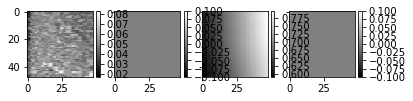

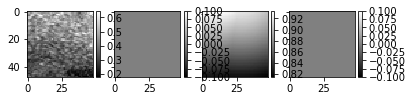

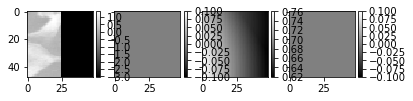

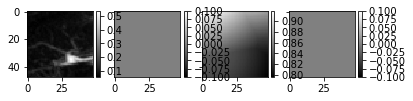

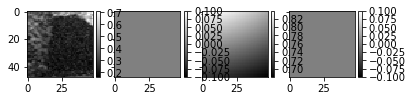

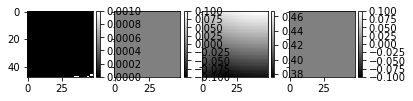

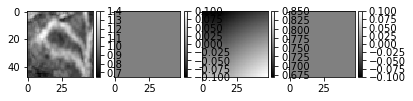

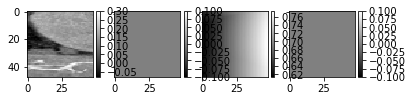

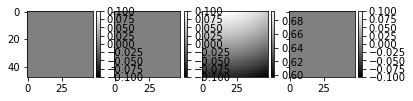

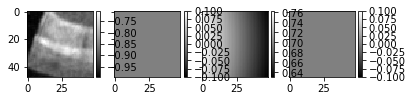

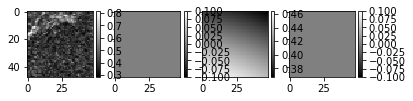

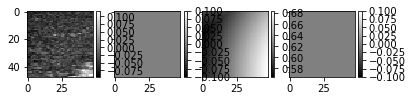

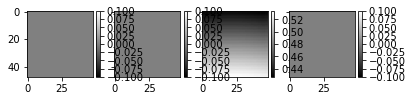

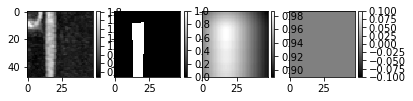

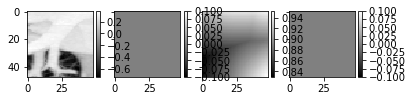

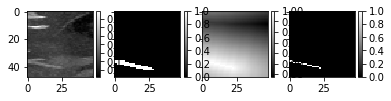

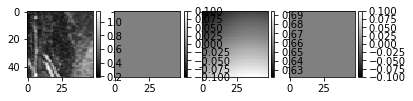

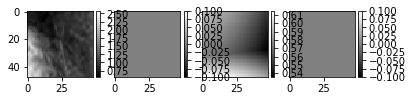

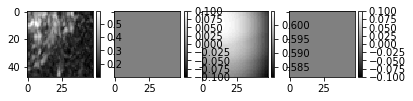

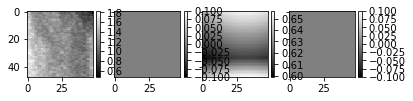

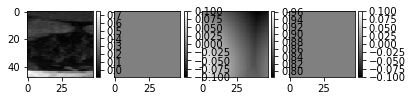

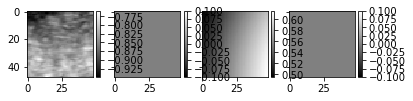

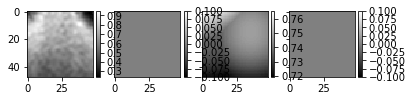

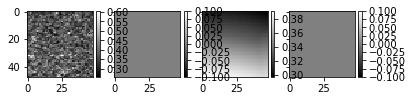

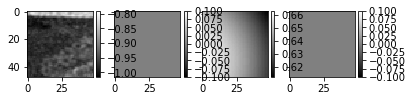

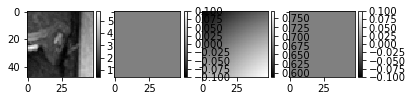

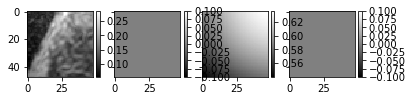

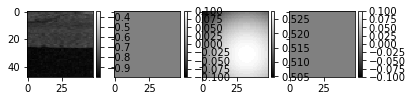

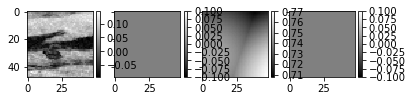

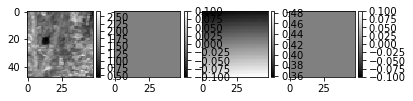

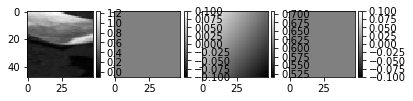

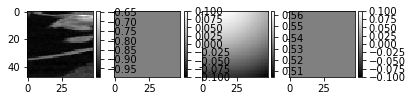

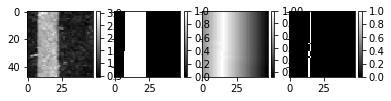

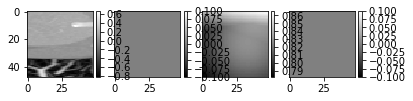

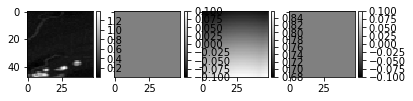

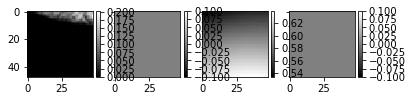

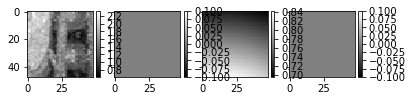

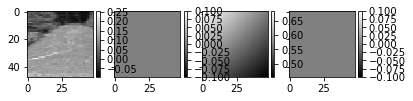

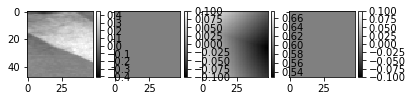

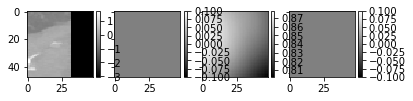

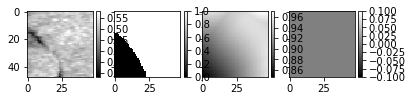

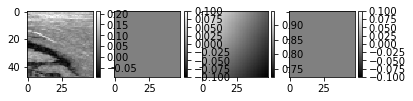

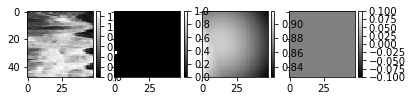

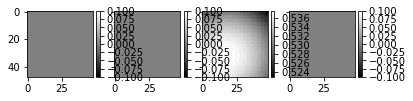

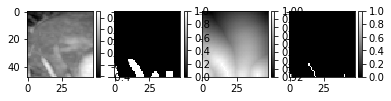

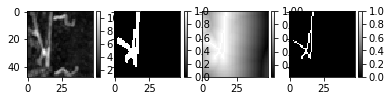

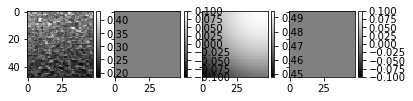

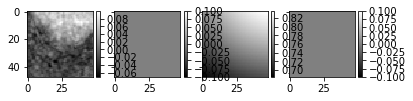

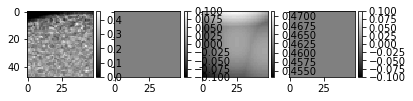

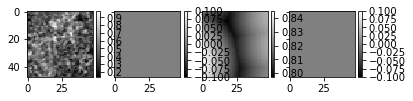

In [10]:
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
for i in range(len(X)):
    j = np.random.randint(len(f.root.X))
    mpx = np.amax(f.root.X[j],axis=(1))
    mpy = np.amax(f.root.Y[j,:,:,:,0],axis=(1))
    mpd = np.amax(f.root.Y[j,:,:,:,1],axis=(1))
    mps = np.amax(f.root.Y[j,:,:,:,2],axis=(1))

    plt.figure()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
    implot(mpx,ax1)
    implot(mpy,ax2)
    implot(mpd,ax3)
    implot(mps,ax4)
    plt.tight_layout
    plt.show()
    
plt.close('all')